# Imports


In [134]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix

from tensorflow import keras
from keras.preprocessing import sequence
from tensorflow.python.keras import Sequential
from keras.models import load_model
from tensorflow.python.keras.layers import Dense, Embedding, GlobalAveragePooling1D

import pickle

##from Helpers_NN import add_sum_suffix, text_cleanup, reverse_encode, add_one_argmax_score, conf_matrix

In [135]:
df = pd.read_csv(r'C:\Users\lenovo\PycharmProjects\pythonProject2\Data\Neural_Networks\neural_network_data.csv')

In [136]:
df['rating'] = df['rating'].fillna((df['rating'].mean()))

In [137]:
df['rating'] = df['rating'].astype(np.int64)

In [138]:
df['review'] = df['review'].astype(str)

In [139]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35563 entries, 0 to 35562
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   rating  35563 non-null  int64 
 1   review  35563 non-null  object
dtypes: int64(1), object(1)
memory usage: 555.8+ KB


# One Hot Encoding Scores Column

In [140]:
enc = OneHotEncoder(handle_unknown='ignore')

enc_df = pd.DataFrame(enc.fit_transform(df[['rating']]).toarray())

df = df.join(enc_df)
df = df.rename(columns={0: "rating_1", 1:'rating_2',2:'rating_3',3:'rating_4',4:'rating_5'})
df.head()

,rating,review,rating_1,rating_2,rating_3,rating_4,rating_5
0,1,Its hard to find words that can describe this ...,1.0,0.0,0.0,0.0,0.0
1,1,"Absolutely terrible. Cracked ceiling, tiny roo...",1.0,0.0,0.0,0.0,0.0
2,1,Very disappointed firstly i checked in online ...,1.0,0.0,0.0,0.0,0.0
3,1,First of all we arrived wanting to park at the...,1.0,0.0,0.0,0.0,0.0
4,1,"Hello, I currently staying @ Hilton Metropole...",1.0,0.0,0.0,0.0,0.0


Train - Test Split

In [141]:
x_train, x_test, y_train, y_test = train_test_split(df[['review']], 
                                                    df[['rating_1','rating_2','rating_3','rating_4','rating_5']], 
                                                    test_size=.2, 
                                                    random_state=42)

In [142]:
y_test.to_csv(r'C:\Users\lenovo\PycharmProjects\pythonProject2\Data\Neural_Networks\y_test_neural.csv',index=False)

In [143]:
x_test.to_csv(r'C:\Users\lenovo\PycharmProjects\pythonProject2\Data\Neural_Networks\x_test_neural.csv')

In [144]:
y_train.to_csv(r'C:\Users\lenovo\PycharmProjects\pythonProject2\Data\Neural_Networks\y_train_neural.csv')
x_train.to_csv(r'C:\Users\lenovo\PycharmProjects\pythonProject2\Data\Neural_Networks\x_train_neural.csv')

#   Noktalama işaretlerini Kaldırılması ve Tokanization Yapılması

In [145]:
from nltk.tokenize import RegexpTokenizer
tokenizer = RegexpTokenizer(r'[a-zA-Z]+')

def text_cleanup(text):

    token_list = tokenizer.tokenize(text.lower())
    new_text = ''
    for word in token_list:
        new_text += word + ' '

    return new_text

In [146]:
x_train['review_cleaned'] = x_train['review'].apply(text_cleanup)
x_test['review_cleaned'] = x_test['review'].apply(text_cleanup)

In [147]:
review_index = 2000
print('REVİEW:', x_train['review'].iloc[review_index],)
print('REVİEW_CLEANED', x_train['review_cleaned'].iloc[review_index])

REVİEW: americans not, stayed resort july 31 august 7. return, open minded people n't complain lot things traveled punta cana mexico jamaica, realize n't states, resort large kids, trams rude people countries jump, no matter traveled great service, figyhting help, spoke spanish helped right away got better service, little bugs room, like ants think came fresh flowers leave room, did not bother, roaches did, bathroom little ones, called sprayed room, day roaches bedroom 1-2 inches long, wanted home, night left 2 suitcases, experience traveled, suitcases came house washed, closed, sewage smell coming bathroom, room broken towel rack mildew did n't bother, towels night 6 00, wet bar sink lifted no water connected, poured water bottle went floor, drain n't connected, felt like total outsider, not treated like, beach grounds awesome, working, sewer plant tram passes sick passed, glad home, 2 days counting days home, happened, food nothing brag, kids survived pasta noodles rice, salad time n

# Her bir kelimenin flat şekilde ayrılması

In [148]:
flat_review = " ".join(x_train['review_cleaned'].values)
flat_review = flat_review.lower().split()

In [149]:
len(flat_review)

2985169

In [150]:
unique_list = []
for word in flat_review:
    if word not in unique_list:
        unique_list.append(word)

In [151]:
len(unique_list)

48179

In [152]:
word_index_dict = {}
for i in range(0,len(unique_list)):
    word_index_dict[unique_list[i]] = i

In [153]:
word_index_dict = {k:(v+4) for k,v in word_index_dict.items()}
word_index_dict['<PAD>'] = 0
word_index_dict['<START>'] = 1
word_index_dict['<UNK>'] = 2
word_index_dict['<UNUSED>'] = 3

# Indexing Words in Reviews Using Dictionary

In [154]:
def index_review_words(text):
    review_word_list = []
    for word in text.lower().split():
        if word in word_index_dict.keys():
            review_word_list.append(word_index_dict[word])
        else:
            review_word_list.append(word_index_dict['<UNK>'])

    return review_word_list

In [155]:
x_train['preprocessed_review'] = x_train['review_cleaned'].apply(index_review_words)
x_test['preprocessed_review'] = x_test['review_cleaned'].apply(index_review_words)

In [156]:
x_train.head()

,review,review_cleaned,preprocessed_review
4851,Hotel is what it is. Clean and functional and ...,hotel is what it is clean and functional and f...,"[4, 5, 6, 7, 5, 8, 9, 10, 9, 11, 12, 13, 14, 1..."
1087,Just checked in for a 4 day trip to London (Bu...,just checked in for a day trip to london busin...,"[81, 82, 83, 11, 19, 31, 84, 35, 73, 85, 86, 8..."
5865,We don’t usually report on major chain hotels ...,we don t usually report on major chain hotels ...,"[33, 153, 111, 154, 155, 29, 156, 157, 93, 83,..."
29083,money grabbing charge credit card checkin chec...,money grabbing charge credit card checkin chec...,"[216, 217, 218, 219, 220, 221, 222, 39, 223, 2..."
3954,"OK hotel, but with the Hilton brand you would ...",ok hotel but with the hilton brand you would e...,"[257, 4, 67, 59, 12, 88, 258, 140, 259, 149, 2..."


In [119]:
from keras import preprocessing
import keras
from keras.utils import pad_sequences

In [120]:
from keras_preprocessing.sequence import pad_sequences

In [157]:
x_train = pad_sequences(x_train['preprocessed_review'],value=word_index_dict['<PAD>'],padding='post',maxlen=250)
x_test = pad_sequences(x_test['preprocessed_review'],value=word_index_dict['<PAD>'],padding='post',maxlen=250)

In [50]:
np.save(r'C:\Users\lenovo\PycharmProjects\pythonProject2\Data\Neural_Networks\/x_test',x_test)

In [158]:
x_train.shape

(28450, 250)

In [159]:
y_train.shape

(28450, 5)

In [160]:
x_test.shape

(7113, 250)

In [161]:
y_test.shape


(7113, 5)

In [193]:
unique_list_len = len(unique_list) +1


model = Sequential()
model.add(Embedding(unique_list_len,16, input_length= 250))
model.add(GlobalAveragePooling1D())
model.add(Dense(16,activation='relu'))
model.add(Dense(5,activation='sigmoid'))

In [194]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])


In [195]:
x_train, x_val, y_train, y_val = train_test_split(x_train,y_train,test_size=.2,random_state=42)

In [196]:
fitModel = model.fit(x_train, y_train, epochs=60, batch_size=250, validation_data=(x_val,y_val), verbose=0)

In [197]:
model.evaluate(x_val,y_val)

92/92 [==============================] - 0s 953us/step - loss: 1.2717 - accuracy: 0.6136


[1.2717100381851196, 0.6135895848274231]

In [198]:
model.evaluate(x_test,y_test)

223/223 [==============================] - 0s 906us/step - loss: 1.2442 - accuracy: 0.6092


[1.2441569566726685, 0.6091663241386414]

In [199]:
def reverse_encode(y_df):

    y_df['score'] = (y_df.iloc[:, 0:] == 1).idxmax(1)['score'] = (y_df.iloc[:, 0:] == 1).idxmax(1)
    for i in range(0,len(y_df)):
        if y_df.iloc[i,-1] == 'score_1':
            y_df.iloc[i,-1] = 1
        elif y_df.iloc[i,-1] == 'score_2':
            y_df.iloc[i,-1] = 2
        elif y_df.iloc[i,-1]== 'score_3':
            y_df.iloc[i,-1] = 3
        elif y_df.iloc[i,-1]== 'score_4':
            y_df.iloc[i,-1] = 4
        elif y_df.iloc[i,-1] == 'score_5':
            y_df.iloc[i,-1]= 5

In [200]:
reverse_encode(y_test)

In [201]:
reverse_encode(y_val)

In [202]:
def add_one_argmax_score(x):

    x = x+1

    return x

In [203]:
y_test_predicted = add_one_argmax_score(np.argmax(model.predict(x_test),axis=1))

In [70]:
y_test.to_csv(r'C:\Users\lenovo\PycharmProjects\pythonProject2\Data\Neural_Networks/y_test_nn_df.csv',index=False)
np.save(r'C:\Users\lenovo\PycharmProjects\pythonProject2\Data\Neural_Networks/y_test_predicted_array',y_test_predicted)

In [71]:
y_test['score']

17346    rating_4
8135     rating_5
8904     rating_5
14918    rating_5
14265    rating_5
           ...   
18238    rating_5
18699    rating_4
18348    rating_4
29677    rating_1
4148     rating_3
Name: score, Length: 7113, dtype: object

In [205]:
yy_test =  y_test

yy_test['score'] = yy_test['score'].replace(['rating_1'],1)
yy_test['score'] = yy_test['score'].replace(['rating_2'],2)
yy_test['score'] = yy_test['score'].replace(['rating_3'],3)
yy_test['score'] = yy_test['score'].replace(['rating_4'],4)
yy_test['score'] = yy_test['score'].replace(['rating_5'],5)

In [206]:
yy_test['score'] = yy_test['score'].astype(np.int64)

In [207]:
def conf_matrix(cm):

    plt.figure(figsize=(9,9))
    ax = sns.heatmap(cm,
                     annot= True,
                     fmt = '.4g',
                     cbar=0,
                     xticklabels=[1,2,3,4,5],
                     yticklabels=[1,2,3,4,5])
    ax.set(xlabel='Predicted', ylabel='True')
    plt.show()

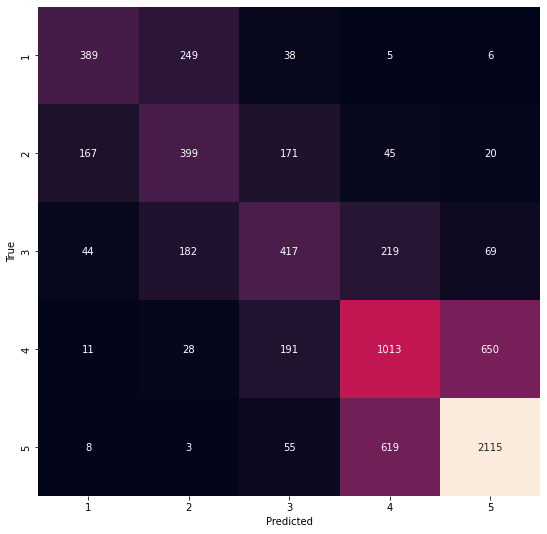

In [208]:
test_cm = confusion_matrix(yy_test['score'], y_test_predicted)
conf_matrix(test_cm)

In [76]:
model.save(r'C:\Users\lenovo\PycharmProjects\pythonProject2\Data\Neural_Networks/Models/Neural_Network.h5')

In [77]:
pickle.dump(word_index_dict,open(r'C:\Users\lenovo\PycharmProjects\pythonProject2\Data\Neural_Networks/word_index_dict.pkl','wb'))